# Data Exploration

In [1]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('baseline')

In [2]:
def json_to_df(json_file=None):
    """ Reads a single JSON file containing the
    shipment information and converts it to a
    structured dataframe
    """
    import pandas as pd
    from pandas.io.json import json_normalize
    import numpy as np
    logger.debug("Converting to dataframe: {}".format(json_file))
    df = pd.read_json(json_file, dtype={"shipment_number": str})
    normalized_df = json_normalize(df['events'])
    df.drop(["events"], axis=1, inplace=True)
    df = pd.concat([df, normalized_df], axis=1)
    if "Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen." == df.tail(1)["status"].item():
        logger.warning("Final delivery state is strange! Ignoring the file {}".format(json_file))
        return
    # Some files have multiple states. It does not make sense!
    if df[df["status"] == "Die Sendung wurde erfolgreich zugestellt."].shape[0] > 1:
        logger.warning("Multiple final states! Ignoring the file {}".format(json_file))
        return
    if df["status"].isnull().any():
        logger.warning("Status column has missing values! Ignoring the file {}".format(json_file))
        return
    if len(df["url"].unique()) > 1:
        logger.warning("Multiple URLs for a single shipment number! Something is wrong")
    if len(df["shipment_number"].unique()) > 1:
        logger.warning("Multiple shipment numbers in the same file. Something is wrong")
    # Ignore the ones which have this status somewhere before the last event. This makes the problem simpler!
    if len(df.index[df["status"] == "Der Empfu00E4nger hat die Sendung in der Filiale abgeholt."].tolist()) > 0:
        if df.index[df["status"] == "Der Empfu00E4nger hat die Sendung in der Filiale abgeholt."].tolist()[0] < len(df):
            return
    if len(df.index[df["status"] == "Die Sendung wurde erfolgreich zugestellt."].tolist()) > 0:
        if df.index[df["status"] == "Die Sendung wurde erfolgreich zugestellt."].tolist()[0] < len(df):
            return
    if len(df.index[df["status"].str.startswith("Die Sendung liegt in der") & df["status"].str.endswith("zur Abholung bereit.")].tolist()) > 0:
        if df.index[df["status"].str.startswith("Die Sendung liegt in der") & df["status"].str.endswith("zur Abholung bereit.")].tolist()[0] < len(df):
            return
    if len(df.index[df["status"] == "Die Sendung in Paketkasten-Anlage eingestellt"].tolist()) > 0:
        if df.index[df["status"] == "Die Sendung in Paketkasten-Anlage eingestellt"].tolist()[0] < len(df):
            return
    df['crawltime'] = pd.to_datetime(df['crawltime'], utc=True)
    df['datum'] = pd.to_datetime(df['datum'], utc=True)
    if df["status"].isnull().values.any():
        logger.warning("Column status has missing values! ShipmentNumber: {}".format(df["shipment_number"].values[0]))
    final_event_array = np.zeros(len(df))
    final_event_array[-1] = 1
    df["is_final_event"] = final_event_array
    return df

In [3]:
def files_to_df(path='../data'):
    """ Convert all files to a single dataframe
    """
    import os
    import pandas as pd
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            if '.json' in file:
                files.append(os.path.join(r, file))
    dfs = [json_to_df(json_file=file) for file in files]
    df = pd.concat(dfs, sort=False)
    return df

In [4]:
df = files_to_df(path='../../data')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `item` has been deprecated and will be removed in a future version
  


### Are there any missing values?

In [5]:
import pandas as pd
def count_missing_values(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    return missing_value_df
missing_value_df = count_missing_values(df)

In [6]:
missing_value_df

,column_name,percent_missing
shipment_number,shipment_number,0.000000
crawltime,crawltime,0.000000
url,url,0.000000
datum,datum,0.000000
status,status,0.000000
ort,ort,48.815166
is_final_event,is_final_event,0.000000


Column "ort" has many missing values. We fill them with "Unbekannt"

In [7]:
def fill_missing_values(df):
    """ Fills missing values of specific columns
    in the data frame with pre-defined values.
    """
    df['ort'].fillna("Unbekannt", inplace=True)
    logger.debug("Filled missing values for ort column")
    return df

In [8]:
df = fill_missing_values(df)

Check again if there are any missing values

In [9]:
count_missing_values(df)

,column_name,percent_missing
shipment_number,shipment_number,0.0
crawltime,crawltime,0.0
url,url,0.0
datum,datum,0.0
status,status,0.0
ort,ort,0.0
is_final_event,is_final_event,0.0


### Data Stats

In [10]:
df.shape

(211, 7)

Number of unique shipment numbers

In [11]:
len(df.shipment_number.unique())

55

### Investigate Data Types

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 0 to 3
Data columns (total 7 columns):
shipment_number    211 non-null object
crawltime          211 non-null datetime64[ns, UTC]
url                211 non-null object
datum              211 non-null datetime64[ns, UTC]
status             211 non-null object
ort                211 non-null object
is_final_event     211 non-null float64
dtypes: datetime64[ns, UTC](2), float64(1), object(4)
memory usage: 13.2+ KB


Everything regarding data types seems to be fine! No need for conversion

### Prepare data for exploration and machine learning

- Given the features "datum", "status" and "ort" we want to predict the next "datum" and hopefully also the next "status" and the next "ort"
- We create 3 new columns. "datum_next", "ort_next" and "status_next".

In [13]:
def create_target_columns(df):
    import numpy as np 

    df['status_next'] = df.groupby(['shipment_number'])['status'].shift(-1)
    df['ort_next'] = df.groupby(['shipment_number'])['ort'].shift(-1)
    df['datum_next'] = df.groupby(['shipment_number'])['datum'].shift(-1)
    # we define values for the case the package is already delivered.
    df.loc[df['is_final_event'] == 1, 'status_next'] = "SuccessDelivery"
    df.loc[df['is_final_event'] == 1, 'ort_next'] = "SuccessDelivery"
    df.loc[df['is_final_event'] == 1, 'datum_next'] = np.datetime64('today')
    
    return df

In [14]:
# Disable warnings
pd.set_option('mode.chained_assignment', None)
df = create_target_columns(df)

In [15]:
df.head()

,shipment_number,crawltime,url,datum,status,ort,is_final_event,status_next,ort_next,datum_next
0,00340434188193345907,2019-12-12 13:38:13+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2019-12-10 15:27:00+00:00,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,0.0,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,2019-12-10 18:56:00
1,00340434188193345907,2019-12-12 13:38:13+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2019-12-10 18:56:00+00:00,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,0.0,Die Sendung ist in der Region des Empfu00E4nge...,Bu00F6rnicke,2019-12-11 03:59:00
2,00340434188193345907,2019-12-12 13:38:13+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2019-12-11 03:59:00+00:00,Die Sendung ist in der Region des Empfu00E4nge...,Bu00F6rnicke,0.0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,2019-12-11 10:01:00
3,00340434188193345907,2019-12-12 13:38:13+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2019-12-11 10:01:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung konnte nicht zugestellt werden und...,Unbekannt,2019-12-11 11:25:00
4,00340434188193345907,2019-12-12 13:38:13+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2019-12-11 11:25:00+00:00,Die Sendung konnte nicht zugestellt werden und...,Unbekannt,0.0,Die Sendung wird zur Abholung in die &lt;a hre...,Unbekannt,2019-12-11 17:14:00


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 0 to 3
Data columns (total 10 columns):
shipment_number    211 non-null object
crawltime          211 non-null datetime64[ns, UTC]
url                211 non-null object
datum              211 non-null datetime64[ns, UTC]
status             211 non-null object
ort                211 non-null object
is_final_event     211 non-null float64
status_next        211 non-null object
ort_next           211 non-null object
datum_next         211 non-null datetime64[ns]
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), float64(1), object(6)
memory usage: 18.1+ KB


### Data Stats

In [17]:
count_missing_values(df)

,column_name,percent_missing
shipment_number,shipment_number,0.0
crawltime,crawltime,0.0
url,url,0.0
datum,datum,0.0
status,status,0.0
ort,ort,0.0
is_final_event,is_final_event,0.0
status_next,status_next,0.0
ort_next,ort_next,0.0
datum_next,datum_next,0.0


In [18]:
df.shape

(211, 10)

Number of unique shipment numbers

In [19]:
len(df.shipment_number.unique())

55

In [20]:
len(df.status.unique())

21

In [21]:
len(df.ort.unique())

29

### How many different final delivery states exist?

In [22]:
final_delivery_states = df.groupby(['shipment_number']).tail(1)[["status"]]["status"].unique()
print(final_delivery_states)

["Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address= ' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale &lt;/a&gt; gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden."
 'Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.'
 'Die Sendung wurde in das Zustellfahrzeug geladen. Die Zustellung erfolgt voraussichtlich heute.'
 "Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Oberhausen Weierstr. 195' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Oberhausen Weierstr. 195&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich."
 'Die Sendung konnte nicht zugestellt werden und wird in eine Packstation gebracht.'
 'Die Sendung ist

### How many different initial delivery states exist?

In [23]:
initial_delivery_states = df.groupby(['shipment_number']).head(1)[["status"]]["status"].unique()
print(initial_delivery_states)

['Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.']


### Distribution of all states

These are the most common states

In [24]:
pd.DataFrame(df["status"].value_counts()).head(10)

,status
Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.,58
"Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.",55
Die Sendung ist in der Region des Empfu00E4ngers angekommen und wird im nu00E4chsten Schritt zur Zustellbasis transportiert.,35
Die Sendung wurde in das Zustellfahrzeug geladen. Die Zustellung erfolgt voraussichtlich heute.,29
Die Sendung wird fu00FCr die Verladung ins Zustellfahrzeug vorbereitet.,10
Die Sendung konnte nicht zugestellt werden und wird in die Filiale gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,6
Die Sendung wird fu00FCr den Weitertransport vorbereitet.,3
Die Sendung konnte nicht zugestellt werden und wird in eine Packstation gebracht.,2
"Die Sendung befindet sich wie gewu00FCnscht auf dem Weg zur Filiale. Sie werden informiert, sobald die Sendung in der Filiale eingetroffen ist.",1
Die Zustellung am gewu00FCnschten Liefertag 14.12.2019 wurde gewu00E4hlt.,1


These are the least common states. What we see here is that there are some states that are basically the same and the following pattern:

"Die Sendung liegt in der ........ zur Abholung bereit"

But the address is each time different. This leads to too many states, which also makes machine learning hard. We ignore the address part and convert all these states to a single one.

In [25]:
pd.DataFrame(df["status"].value_counts()).tail(10)

,status
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Oldenburg Nadorster+Str. 70' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Oldenburg Nadorster Str. 70&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Oberhausen Weierstr. 195' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Oberhausen Weierstr. 195&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,1
Die Sendung befindet sich in der Zustellbasis und wird fu00FCr die Auslieferung vorbereitet.,1
"Leider war eine Zustellung der Sendung nicht mu00F6glich. Gru00FCnde hierfu00FCr ku00F6nnen sein: Kein Zugang zum Gebu00E4ude, kein Schild an der Klingel, Empfu00E4nger ggf. verzogen, etc.",1
Die Sendung wird zum Weitertransport vorbereitet.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=M%C3%BCnchen Kaflerstr. 2' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Mu00FCnchen Kaflerstr. 2&lt;/a&gt; gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.,1
Ihr Paket wird bei uns gelagert und am gewu00FCnschten Liefertag zugestellt.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address= ' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale &lt;/a&gt; gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.,1
Die Sendung wurde zur Abholung in die &lt;a href='http://standorte.deutschepost.de/Standortsuche?standorttyp=filialen_verkaufspunkteu0026ort=Bonnu0026strasse=Endenicher+Str.u0026hausnummer=333u0026postleitzahl=53121u0026lang=de' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Endenicher Str. 333 53121 Bonn&lt;/a&gt; gebracht.,1
Die Sendung befindet sich auf dem Weg zur Packstation.,1


In [26]:
df.loc[(df['status'].str.startswith("Die Sendung liegt in der")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt in der ... zur Abholung bereit." 
df.loc[(df['status'].str.startswith("Die Sendung liegt ab sofort in der Filiale")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit."
df.loc[(df['status'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status'].str.endswith("gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.")), "status"] = "Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich." 
df.loc[(df['status'].str.startswith("Die Sendung wurde zur Abholung in die")) & (df['status'].str.endswith("gebracht.")), "status"] = "Die Sendung wurde zur Abholung in die ... gebracht." 
df.loc[(df['status'].str.startswith("Die Zustellung am gewu00FCnschten Liefertag")) & (df['status'].str.endswith("wurde gewu00E4hlt.")), "status"] = "Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt." 
df.loc[(df['status'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status'].str.endswith("gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.")), "status"] = "Die Sendung wird zur Abholung in die ... gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden." 


df.loc[(df['status_next'].str.startswith("Die Sendung liegt in der")) & (df['status_next'].str.endswith("zur Abholung bereit.")), "status_next"] = "Die Sendung liegt in der ... zur Abholung bereit." 
df.loc[(df['status'].str.startswith("Die Sendung liegt ab sofort in der Filiale")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit."
df.loc[(df['status_next'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status_next'].str.endswith("gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.")), "status_next"] = "Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich." 
df.loc[(df['status_next'].str.startswith("Die Sendung wurde zur Abholung in die")) & (df['status_next'].str.endswith("gebracht.")), "status_next"] = "Die Sendung wurde zur Abholung in die ... gebracht." 
df.loc[(df['status_next'].str.startswith("Die Zustellung am gewu00FCnschten Liefertag")) & (df['status_next'].str.endswith("wurde gewu00E4hlt.")), "status_next"] = "Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt." 
df.loc[(df['status_next'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status_next'].str.endswith("gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.")), "status_next"] = "Die Sendung wird zur Abholung in die ... gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden." 

In [27]:
pd.DataFrame(df["status"].value_counts()).head(10)

,status
Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.,58
"Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.",55
Die Sendung ist in der Region des Empfu00E4ngers angekommen und wird im nu00E4chsten Schritt zur Zustellbasis transportiert.,35
Die Sendung wurde in das Zustellfahrzeug geladen. Die Zustellung erfolgt voraussichtlich heute.,29
Die Sendung wird fu00FCr die Verladung ins Zustellfahrzeug vorbereitet.,10
Die Sendung konnte nicht zugestellt werden und wird in die Filiale gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,6
Die Sendung wird fu00FCr den Weitertransport vorbereitet.,3
Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,2
Die Sendung wird zur Abholung in die ... gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.,2
Die Sendung konnte nicht zugestellt werden und wird in eine Packstation gebracht.,2


In [28]:
pd.DataFrame(df["status"].value_counts()).tail(10)

,status
Die Sendung konnte nicht zugestellt werden und wird in eine Packstation gebracht.,2
"Die Sendung befindet sich wie gewu00FCnscht auf dem Weg zur Filiale. Sie werden informiert, sobald die Sendung in der Filiale eingetroffen ist.",1
"Leider war eine Zustellung der Sendung nicht mu00F6glich. Gru00FCnde hierfu00FCr ku00F6nnen sein: Kein Zugang zum Gebu00E4ude, kein Schild an der Klingel, Empfu00E4nger ggf. verzogen, etc.",1
Die Sendung befindet sich in der Zustellbasis und wird fu00FCr die Auslieferung vorbereitet.,1
Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt.,1
Die Sendung wird zum Weitertransport vorbereitet.,1
Die Sendung wurde zur Abholung in die ... gebracht.,1
Ihr Paket wird bei uns gelagert und am gewu00FCnschten Liefertag zugestellt.,1
Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit.,1
Die Sendung befindet sich auf dem Weg zur Packstation.,1


In [29]:
len(df["status"].unique())

19

In [30]:
len(df["status_next"].unique())

19

### Distribution of the locations

In [31]:
len(df["ort"].unique())

29

In [32]:
pd.DataFrame(df["ort"].value_counts()).head(20)

,ort
Unbekannt,103
Neumu00FCnster,32
Hamburg,26
Staufenberg,4
Dorsten,4
Augsburg,3
Bremen GVZ,3
Speyer,3
Bu00F6rnicke,3
Bremen,2


In [33]:
pd.DataFrame(df["ort"].value_counts()).tail(20)

,ort
Bremen,2
Dinslaken (MechZB),2
Ku00F6ngen,2
Hamm MechZB,2
Oldenburg MechZB,2
Obertshausen,2
Germering MechZB,2
Bielefeld,2
Kitzingen,2
Ottendorf-Okrilla,2


Notice: One idea here could be to merge some locations. 

### Remove unused columns

In [34]:
df.drop(columns=["crawltime", "url"], inplace=True)

In [35]:
df.head()

,shipment_number,datum,status,ort,is_final_event,status_next,ort_next,datum_next
0,00340434188193345907,2019-12-10 15:27:00+00:00,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,0.0,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,2019-12-10 18:56:00
1,00340434188193345907,2019-12-10 18:56:00+00:00,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,0.0,Die Sendung ist in der Region des Empfu00E4nge...,Bu00F6rnicke,2019-12-11 03:59:00
2,00340434188193345907,2019-12-11 03:59:00+00:00,Die Sendung ist in der Region des Empfu00E4nge...,Bu00F6rnicke,0.0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,2019-12-11 10:01:00
3,00340434188193345907,2019-12-11 10:01:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung konnte nicht zugestellt werden und...,Unbekannt,2019-12-11 11:25:00
4,00340434188193345907,2019-12-11 11:25:00+00:00,Die Sendung konnte nicht zugestellt werden und...,Unbekannt,0.0,Die Sendung wird zur Abholung in die ... gebra...,Unbekannt,2019-12-11 17:14:00


### Time diff between events

In [36]:
df['datum'] = pd.to_datetime(df['datum'], utc=True)
df['datum_next'] = pd.to_datetime(df['datum_next'], utc=True)
df["datum_diff"] = df["datum_next"] - df["datum"]

Notice that for is_final_event=1, the datum_diff does not make any sense. Do not use it in the analysis

In [37]:
df.head()

,shipment_number,datum,status,ort,is_final_event,status_next,ort_next,datum_next,datum_diff
0,00340434188193345907,2019-12-10 15:27:00+00:00,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,0.0,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,2019-12-10 18:56:00+00:00,03:29:00
1,00340434188193345907,2019-12-10 18:56:00+00:00,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,0.0,Die Sendung ist in der Region des Empfu00E4nge...,Bu00F6rnicke,2019-12-11 03:59:00+00:00,09:03:00
2,00340434188193345907,2019-12-11 03:59:00+00:00,Die Sendung ist in der Region des Empfu00E4nge...,Bu00F6rnicke,0.0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,2019-12-11 10:01:00+00:00,06:02:00
3,00340434188193345907,2019-12-11 10:01:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung konnte nicht zugestellt werden und...,Unbekannt,2019-12-11 11:25:00+00:00,01:24:00
4,00340434188193345907,2019-12-11 11:25:00+00:00,Die Sendung konnte nicht zugestellt werden und...,Unbekannt,0.0,Die Sendung wird zur Abholung in die ... gebra...,Unbekannt,2019-12-11 17:14:00+00:00,05:49:00


### Define the problem as a regression problem

In [38]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

This means now that we want to predict the time between two events. The column "datum_diff_h" tells us the time diff betwen the two events in hours

##### First we only use two features. So the question is, given status and ort of an event, can we predict, when the next event will happen?

In [39]:
df_temp = df[df["is_final_event"] == 0]
X = df_temp[["status", "ort"]]
y = df_temp["datum_diff_h"]

Notice that "status" and "ort" are categorical variables. We shoud encode them!

In [40]:
X["status"] = X["status"].astype('category')
X["status_code"] = X["status"].cat.codes
X["ort"] = X["ort"].astype('category')
X["ort_code"] = X["ort"].cat.codes

Create trainig and test set

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [42]:
X.head()

,status,ort,status_code,ort_code
0,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,8,26
1,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,10,12
2,Die Sendung ist in der Region des Empfu00E4nge...,Bu00F6rnicke,2,5
3,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,9,26
4,Die Sendung konnte nicht zugestellt werden und...,Unbekannt,3,26


In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

regr = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0)
regr.fit(X_train[["status_code", "ort_code"]], y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

##### Coefficient of determination R^2 of the prediction with cross validation

In [44]:
cross_val_score(regr, X_train[["status_code", "ort_code"]], y_train, cv=10)

array([-0.18457366,  0.15591046,  0.3964944 ,  0.5085847 ,  0.33235475,
        0.14908121,  0.24366292,  0.08195787,  0.45086146,  0.35141677])

##### Feature Importance

In [45]:
print(regr.feature_importances_)

[0.8445427 0.1554573]


"status" played a bigger role in predictions comparing to "ort"

##### Fit the model and test it on the test set

In [46]:
model = regr.fit(X_train[["status_code", "ort_code"]], y_train)

In [47]:
y_pred = model.predict(X_test[["status_code", "ort_code"]])

##### Metrics

In [48]:
from sklearn import metrics
import numpy as np
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 9.471017869493265
Mean Squared Error: 161.65612447520834
Root Mean Squared Error: 12.714406178630929


##### Distribution of errors

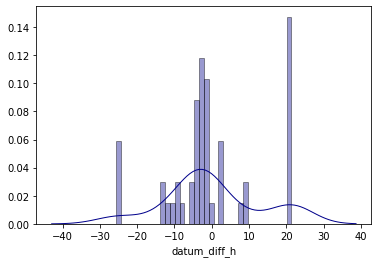

In [64]:
import seaborn as sns
sns.distplot(y_test-y_pred, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

### For which data point do I have a minimal error?

In [50]:
X_test_df = pd.DataFrame(X_test).reset_index(drop=True)
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred).reset_index(drop=True)

In [51]:
prediction_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)

In [52]:
prediction_df.head()

,status,ort,status_code,ort_code,datum_diff_h,0
0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,9,26,5.0,3.158369
1,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,8,26,23.0,27.610746
2,Die Sendung wurde von DHL bearbeitet und wird ...,Neumu00FCnster,10,18,8.0,11.866129
3,Die Sendung wurde von DHL bearbeitet und wird ...,Neumu00FCnster,10,18,8.0,11.866129
4,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,8,26,2.0,27.610746


In [53]:
prediction_df.columns = ['status', 'ort', 'status_code', 'ort_code', 'y', 'y_pred']

In [54]:
prediction_df.head()

,status,ort,status_code,ort_code,y,y_pred
0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,9,26,5.0,3.158369
1,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,8,26,23.0,27.610746
2,Die Sendung wurde von DHL bearbeitet und wird ...,Neumu00FCnster,10,18,8.0,11.866129
3,Die Sendung wurde von DHL bearbeitet und wird ...,Neumu00FCnster,10,18,8.0,11.866129
4,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,8,26,2.0,27.610746


In [55]:
prediction_df["diff"] = abs(prediction_df["y"] - prediction_df["y_pred"])

In [56]:
prediction_df.head()

,status,ort,status_code,ort_code,y,y_pred,diff
0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,9,26,5.0,3.158369,1.841631
1,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,8,26,23.0,27.610746,4.610746
2,Die Sendung wurde von DHL bearbeitet und wird ...,Neumu00FCnster,10,18,8.0,11.866129,3.866129
3,Die Sendung wurde von DHL bearbeitet und wird ...,Neumu00FCnster,10,18,8.0,11.866129,3.866129
4,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,8,26,2.0,27.610746,25.610746


In [62]:
prediction_df[prediction_df["diff"] > 25].values

array([['Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.',
        'Unbekannt', 8, 26, 2.0, 27.61074641631514, 25.61074641631514],
       ['Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.',
        'Unbekannt', 8, 26, 2.0, 27.61074641631514, 25.61074641631514]],
      dtype=object)